In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pickle
from tqdm import tqdm
from NegativeClassOptimization import ml, visualisations #SNN, train_loop, test_loop

In [2]:
targets_balanced_list = ['Q96GD4', 'P49841', 'Q13627', 'P06239', 'Q13464', 'P11309']
tasks = ["vs_Weak", "vs_Non-binder", "vs_all", "shuffled_weak"]


In [3]:
def compute_performance(targets_balanced_list, tasks, model_type):
    records = []
    for target in tqdm(targets_balanced_list, desc="Targets"):
        for split in tqdm([0,1,2,42], desc="Splits"):
            for train_task in tqdm(tasks, desc="Train tasks"):
                path_model = Path('./data/processed') / target / train_task / f'split_{split}' / 'ml_models' / model_type
                state_dict = torch.load(path_model)
                model = ml.load_model_from_state_dict(state_dict)

                for test_task in tqdm(tasks, desc="Test tasks"):
                    path_to_target = Path('./data/processed') / target
                    path_vs_task_split = path_to_target / test_task / f'split_{split}'
                    path_to_test = path_vs_task_split / 'test.pkl'
                    test_dataset = pd.read_pickle(path_to_test)

                    if test_task == train_task:
                        test_type = "closed"
                    else:
                        test_type = "open"

                    # Testing
                    with torch.no_grad():
                        X = np.array(test_dataset["X"].tolist())
                        X_tensor = torch.tensor(X, dtype=torch.float32)  # type: ignore
                        y_pred = model(X_tensor).round().detach().numpy().reshape(-1)
                        y_true = test_dataset["Y_binary"].values
                        metrics = ml.compute_binary_metrics(y_pred, y_true)
                    records.append([target, train_task, test_task, split, test_type, metrics["acc"], metrics["precision"], metrics["recall"], metrics["f1"]])
    df_performance = pd.DataFrame(records, columns=["target", "train_task", "test_task", "split", "test_type", "accuracy", "precision", "recall", "f1"])
    return df_performance


In [4]:
#let's make a function 
model_type = 'swa_SN10.pt'
df_performance_SN10 = compute_performance(targets_balanced_list, tasks, model_type)

Targets:   0%|          | 0/6 [00:00<?, ?it/s]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_56906/4274241881.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [5]:
"""#let's make a function 
model_type = 'swa_SN20.pt'
df_performance_SN10 = compute_performance(targets_balanced_list, tasks, model_type)"""

"#let's make a function \nmodel_type = 'swa_SN20.pt'\ndf_performance_SN10 = compute_performance(targets_balanced_list, tasks, model_type)"

In [6]:
#df_closed_SN20 = df_performance_SN20.query("test_type == 'closed'")
df_closed_SN10= df_performance_SN10.query("test_type == 'closed'")

In [7]:
"""sns.boxplot(data=df_closed_SN20, x="train_task", y="accuracy", hue="target")
plt.ylabel("Closed accuracy")
plt.xlabel("Task")
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.2), ncol=6)"""

'sns.boxplot(data=df_closed_SN20, x="train_task", y="accuracy", hue="target")\nplt.ylabel("Closed accuracy")\nplt.xlabel("Task")\nplt.legend(loc=\'center\', bbox_to_anchor=(0.5, -0.2), ncol=6)'

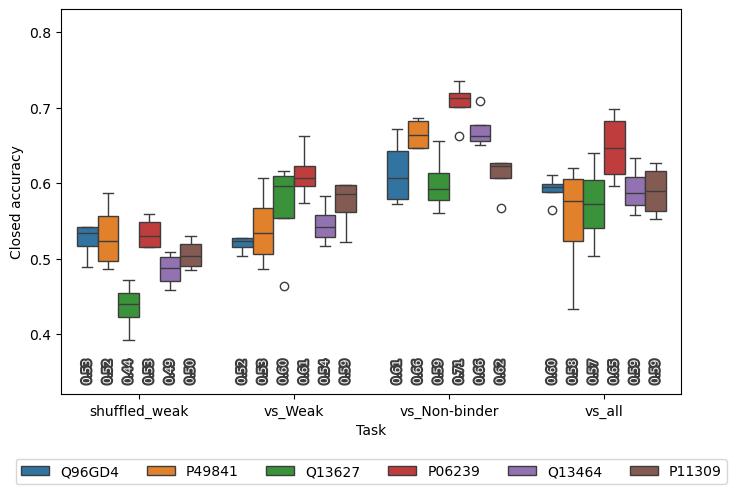

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=df_closed_SN10, x="train_task", y="accuracy", hue="target", order=["shuffled_weak", "vs_Weak", "vs_Non-binder", "vs_all"])
plt.ylim(0.32,0.83)

visualisations.add_median_labels(ax, y_level=0.35, fontsize=8)
ax.set_ylabel("Closed accuracy")
ax.set_xlabel("Task")
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.2), ncol=6)

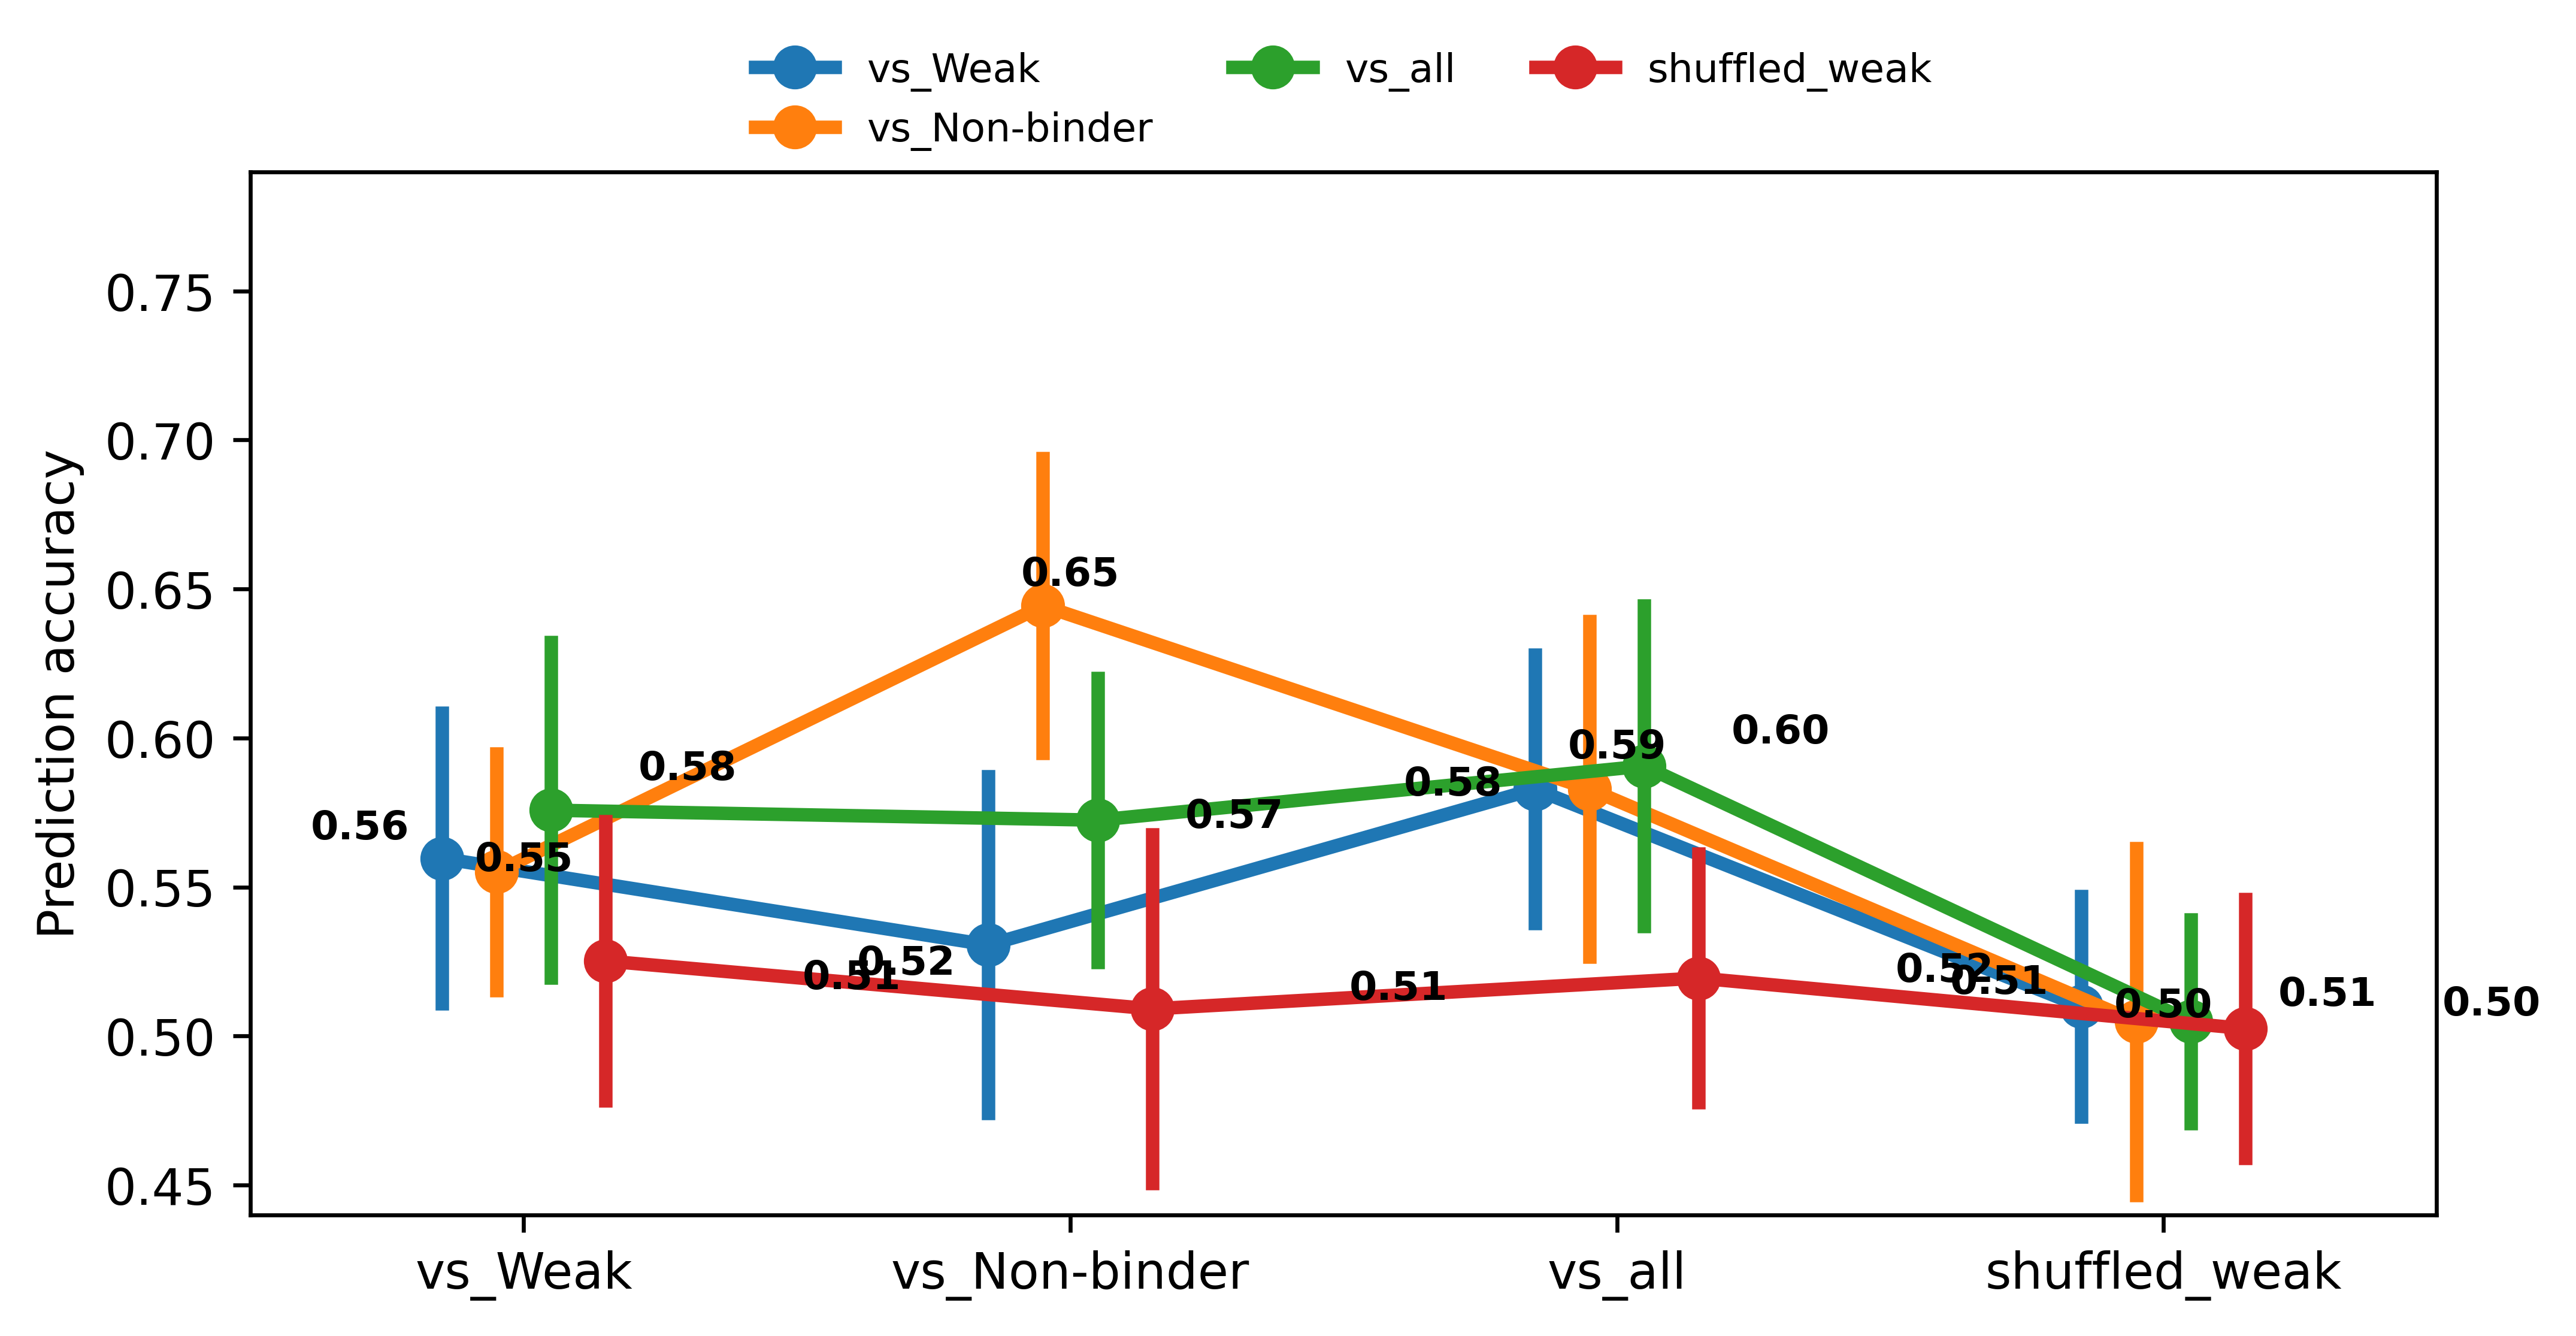

In [9]:
#now I need to plot openset performance
fig, ax = plt.subplots(figsize=(2.5 * 3.14, 1.2 * 3.14), dpi=600)
sns.pointplot(
    df_performance_SN10,
    y="accuracy",
    x="test_task",
    errorbar="sd",
    hue="train_task",
    dodge=0.3,
    ax=ax,
)

# Add legend horizontally on top of plot area, outside plot area
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=3,
    fontsize=8,
    frameon=False,
    # title="Model trained on",
    # title_fontsize=8,
)

ax.set_xlabel(None)
ax.set_ylabel("Prediction accuracy")
ax.set_ylim(0.44, 0.79)

# Add text

medians = df_performance_SN10.groupby(['test_task', 'train_task'])['accuracy'].median().reset_index()
for i, row in medians.iterrows():
    test_task = row['test_task']
    train_task = row['train_task']
    median_val = row['accuracy']
    x = ax.get_xticks()[list(df_performance_SN10['test_task'].unique()).index(test_task)]
    hue_offset = list(df_performance_SN10['train_task'].unique()).index(train_task) * 0.3 - 0.3
    ax.text(
        x + hue_offset,
        median_val,
        f"{median_val:.2f}",
        ha="center",
        va="bottom",
        color="black",
        fontsize=8,
        fontweight="bold",
    )

In [9]:
df_performance_SN20.head()

,target,train_task,test_task,split,test_type,accuracy,precision,recall,f1
0,Q96GD4,vs_Weak,vs_Weak,0,closed,0.534351,0.539683,0.515152,0.527132
1,Q96GD4,vs_Weak,vs_Non-binder,0,open,0.526718,0.531250,0.515152,0.523077
2,Q96GD4,vs_Weak,vs_all,0,open,0.519084,0.523077,0.515152,0.519084
3,Q96GD4,vs_Non-binder,vs_Weak,0,open,0.580153,0.575342,0.636364,0.604317
4,Q96GD4,vs_Non-binder,vs_Non-binder,0,closed,0.610687,0.608696,0.636364,0.622222


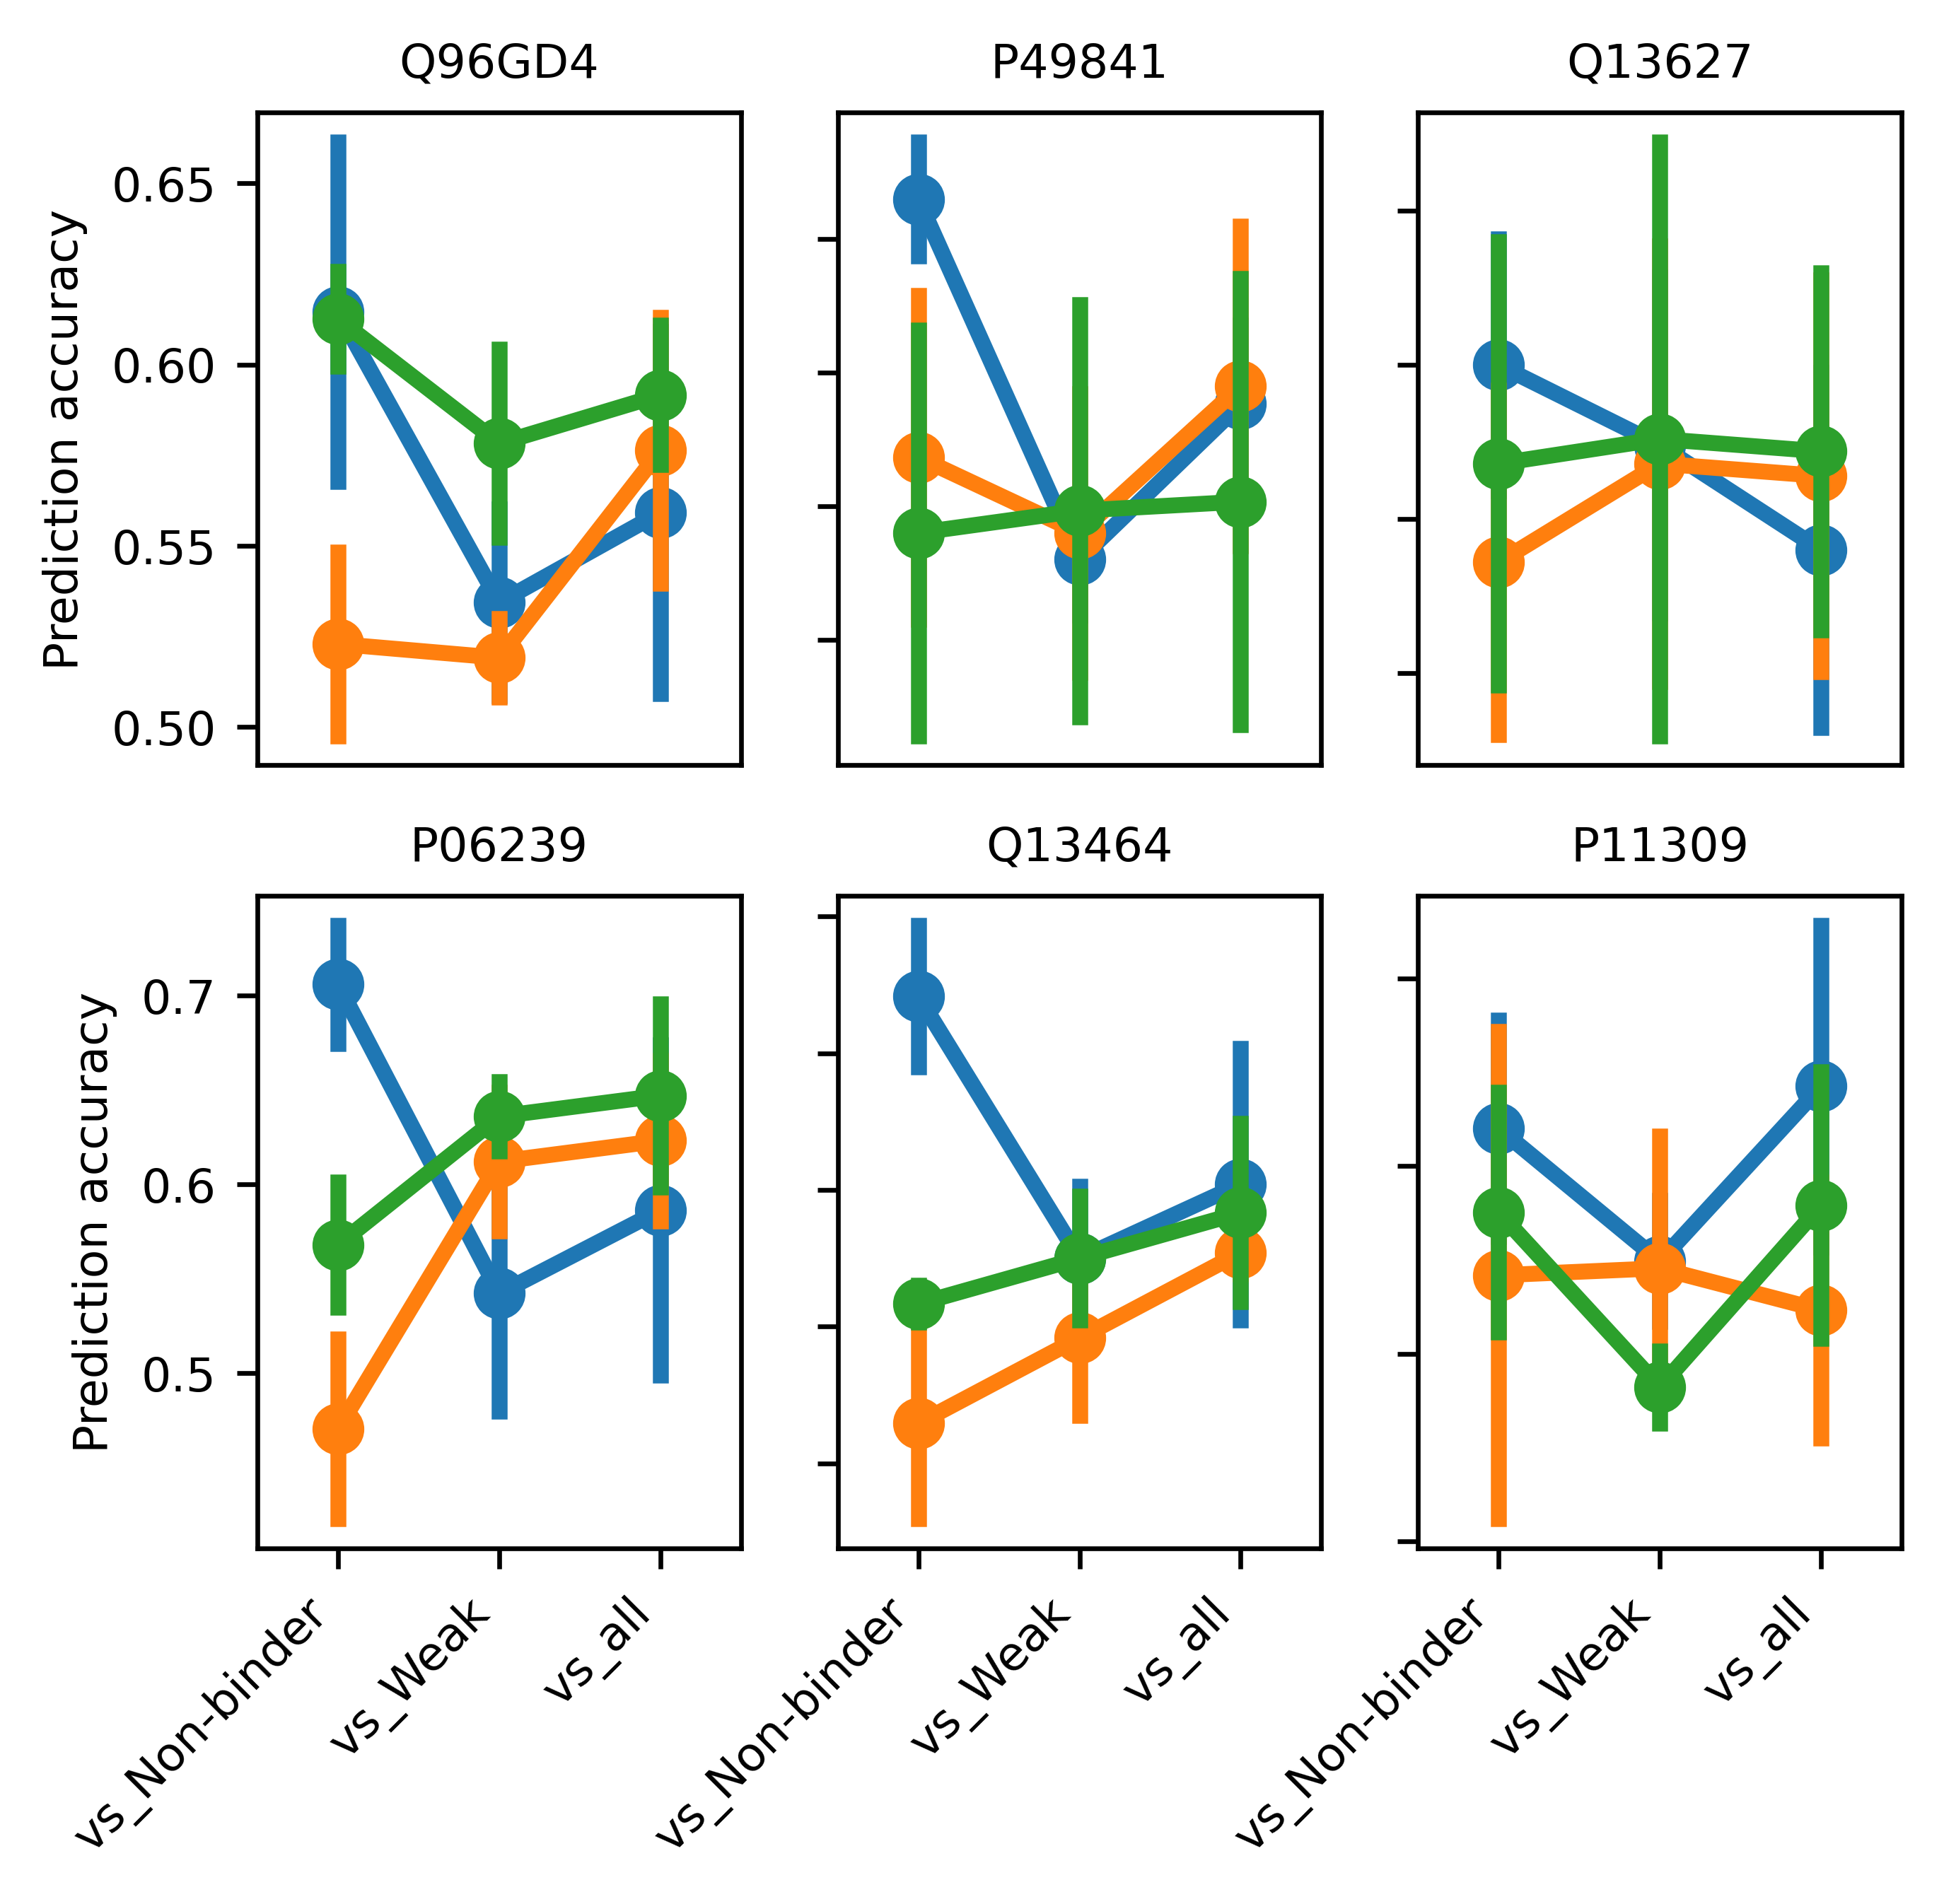

In [32]:

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(2.5 * 2, 1.4 * 3.14), dpi=600)

task_order = ["vs_Non-binder", "vs_Weak", "vs_all"]

for i, target in enumerate(targets_balanced_list):
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    df_i = df_performance_SN10.query("target == @target")
    sns.pointplot(
        df_i,
        x="test_task",
        y="accuracy",
        order=task_order,
        hue="train_task",
        hue_order=task_order,
        errorbar="sd",
        # palette=visualisations.PlotParams.cmap_tasks_no1v1,
        ax=ax,
    )

    ax.legend().remove()

    ax.set_xlabel(None)
    if row == 0:
        ax.set_xticks([])
    elif row == 1:
        for tick in ax.get_xticklabels():
            # tick.set_rotation(45)
            # 45 degree rotation, but with the text centered
            tick.set_rotation(45)
            tick.set_horizontalalignment("right")

    if col == 0:
        ax.set_ylabel("Prediction accuracy", fontsize=8)
    else:
        ax.set_yticklabels([])
        ax.set_ylabel(None)

    ax.set_title(f"{target}", fontsize=8)
    ax.tick_params(axis="both", which="major", labelsize=8)


/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_11203/916955768.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


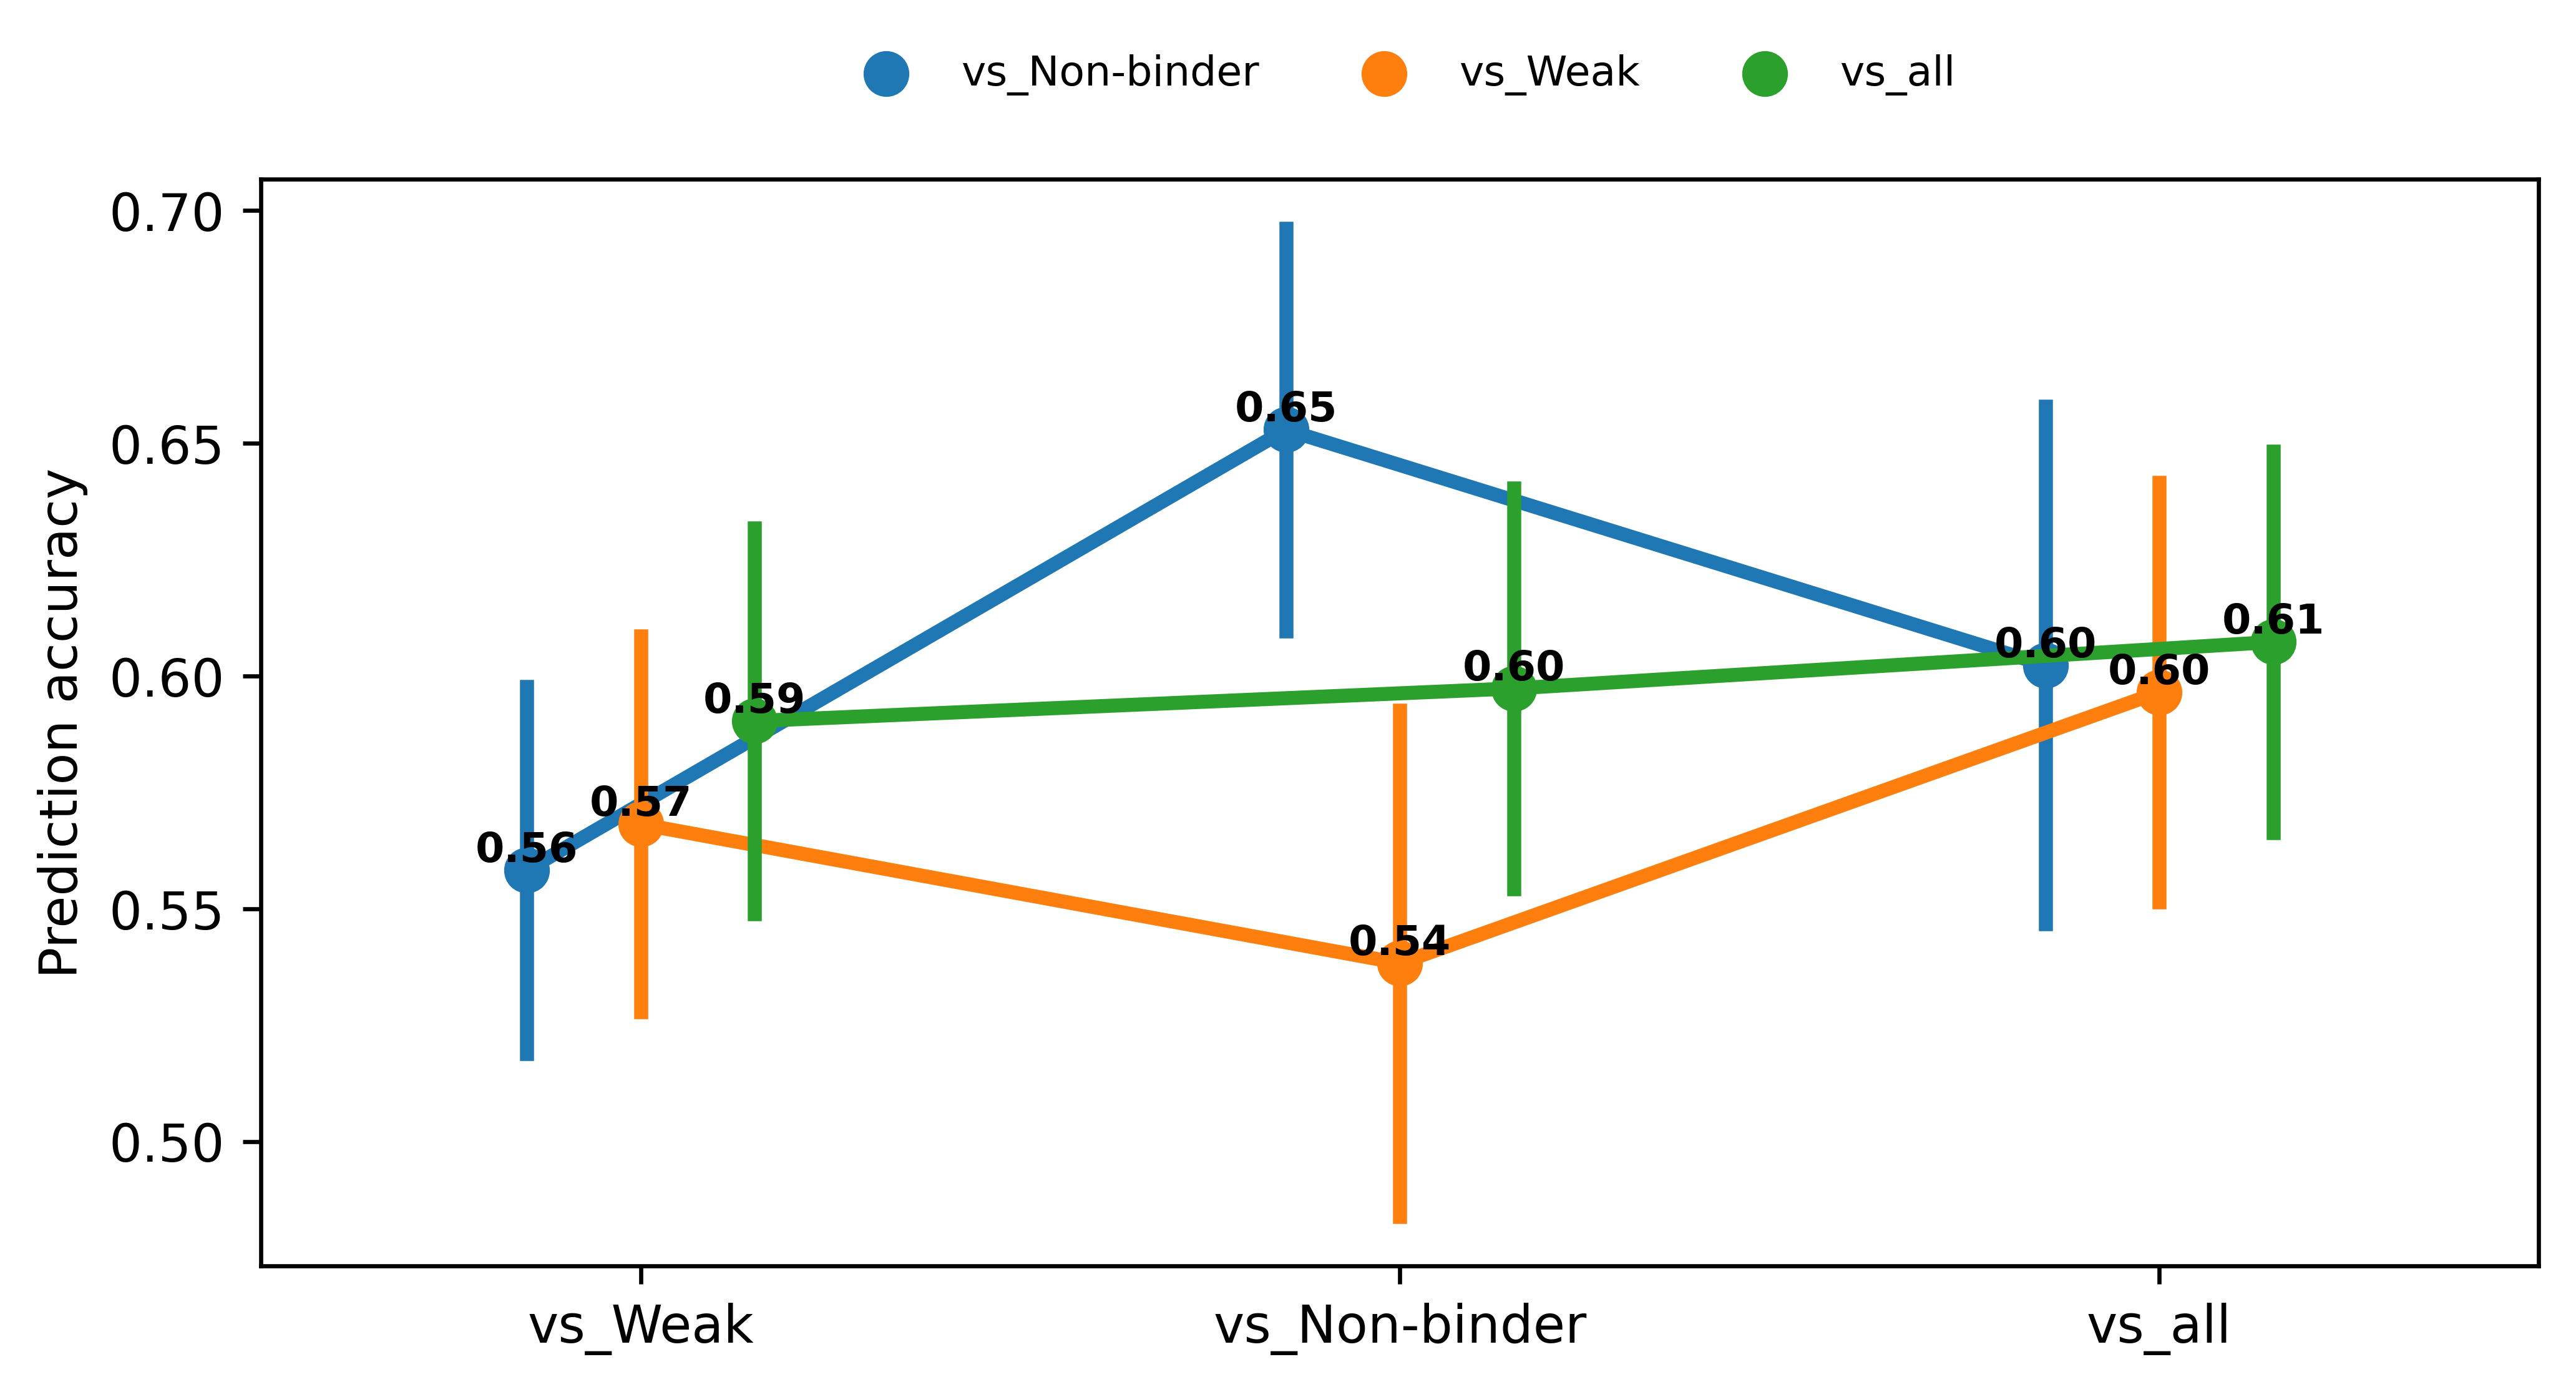

In [37]:
#now I need to plot openset performance
fig, ax = plt.subplots(figsize=(2.5 * 3.14, 1.2 * 3.14), dpi=600)
sns.pointplot(
    df_performance_SN20,
    y="accuracy",
    x="test_task",
    errorbar="sd",
    hue="train_task",
    dodge=0.3,
    ax=ax,
    hue_order=task_order,
)

# Add legend horizontally on top of plot area, outside plot area
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=3,
    fontsize=8,
    frameon=False,
    # title="Model trained on",
    # title_fontsize=8,
)

ax.set_xlabel(None)
ax.set_ylabel("Prediction accuracy")

# Add text
for i, col in enumerate(ax.collections):
    for j, txt in enumerate(col.get_offsets()[:, 0]):
        ax.text(
            txt,
            col.get_offsets()[j, 1],
            f"{col.get_offsets()[j, 1]:.2f}",
            ha="center",
            va="bottom",
            color="black",
            fontsize=8,
            fontweight="bold",
        )

fig.show()

In [18]:
COMPUTE_PERFORMANCE = True
if COMPUTE_PERFORMANCE:
    records = []
    for target in tqdm(targets_balanced_list, desc="Targets"):
        for split in tqdm([0,1,2,42], desc="Splits"):
            for train_task in tqdm(tasks, desc="Train tasks"):
                path_model = Path('./data/processed') / target / train_task / f'split_{split}' / 'ml_models' / 'SN10.pt'
                model = ml.SNN(num_hidden_units=10, input_dim=6700)
                model.load_state_dict(torch.load(path_model))

                for test_task in tqdm(tasks, desc="Test tasks"):
                    path_to_target = Path('./data/processed') / target
                    path_vs_task_split = path_to_target / test_task / f'split_{split}'
                    path_to_test = path_vs_task_split / 'test.pkl'
                    test_dataset = pd.read_pickle(path_to_test)

                    if test_task == train_task:
                        test_type = "closed"
                    else:
                        test_type = "open"

                    # Testing
                    with torch.no_grad():
                        X = np.array(test_dataset["X"].tolist())
                        X_tensor = torch.tensor(X, dtype=torch.float32)  # type: ignore
                        y_pred = model(X_tensor).round().detach().numpy().reshape(-1)
                        y_true = test_dataset["Y_binary"].values
                        metrics = ml.compute_binary_metrics(y_pred, y_true)
                    records.append([target, train_task, test_task, split, test_type, metrics["acc"], metrics["precision"], metrics["recall"], metrics["f1"]])
    df_performance_nswa = pd.DataFrame(records, columns=["target", "train_task", "test_task", "split", "test_type", "accuracy", "precision", "recall", "f1"])

Targets:   0%|          | 0/6 [00:00<?, ?it/s]




Test tasks: 100%|██████████| 3/3 [00:00<00:00, 26.90it/s]



Test tasks: 100%|██████████| 3/3 [00:00<00:00, 52.23it/s]


Test tasks: 100%|██████████| 3/3 [00:00<00:00, 51.44it/s]

Train tasks: 100%|██████████| 3/3 [00:00<00:00, 11.23it/s]



Test tasks: 100%|██████████| 3/3 [00:00<00:00, 47.79it/s]


Test tasks: 100%|██████████| 3/3 [00:00<00:00, 47.65it/s]



Train tasks: 100%|██████████| 3/3 [00:00<00:00, 14.06it/s]



Test tasks: 100%|██████████| 3/3 [00:00<00:00, 38.23it/s]



Test tasks: 100%|██████████| 3/3 [00:00<00:00, 57.45it/s]


Test tasks: 100%|██████████| 3/3 [00:00<00:00, 67.05it/s]

Train tasks: 100%|██████████| 3/3 [00:00<00:00, 12.85it/s]





Test tasks: 100%|██████████| 3/3 [00:00<00:00, 27.86it/s]



Test tasks: 100%|██████████| 3/3 [00:00<00:00, 71.91it/s]


Test tasks: 100%|██████████| 3/3 [00:00<00:00, 74.89it/s]

Targets:  17%|█▋        | 1/6 [00:01<00:05,  1.01s/it]


Test tasks: 100%|██████████| 3/3 [00:00<00:

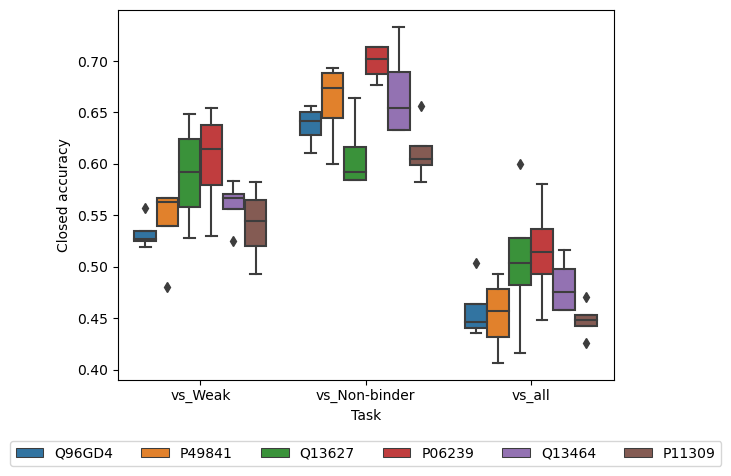

In [19]:
df_closed_nswa = df_performance_nswa.query("test_type == 'closed'")
sns.boxplot(data=df_closed_nswa, x="train_task", y="accuracy", hue="target")
plt.ylabel("Closed accuracy")
plt.xlabel("Task")
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.2), ncol=6)

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_40343/98771209.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


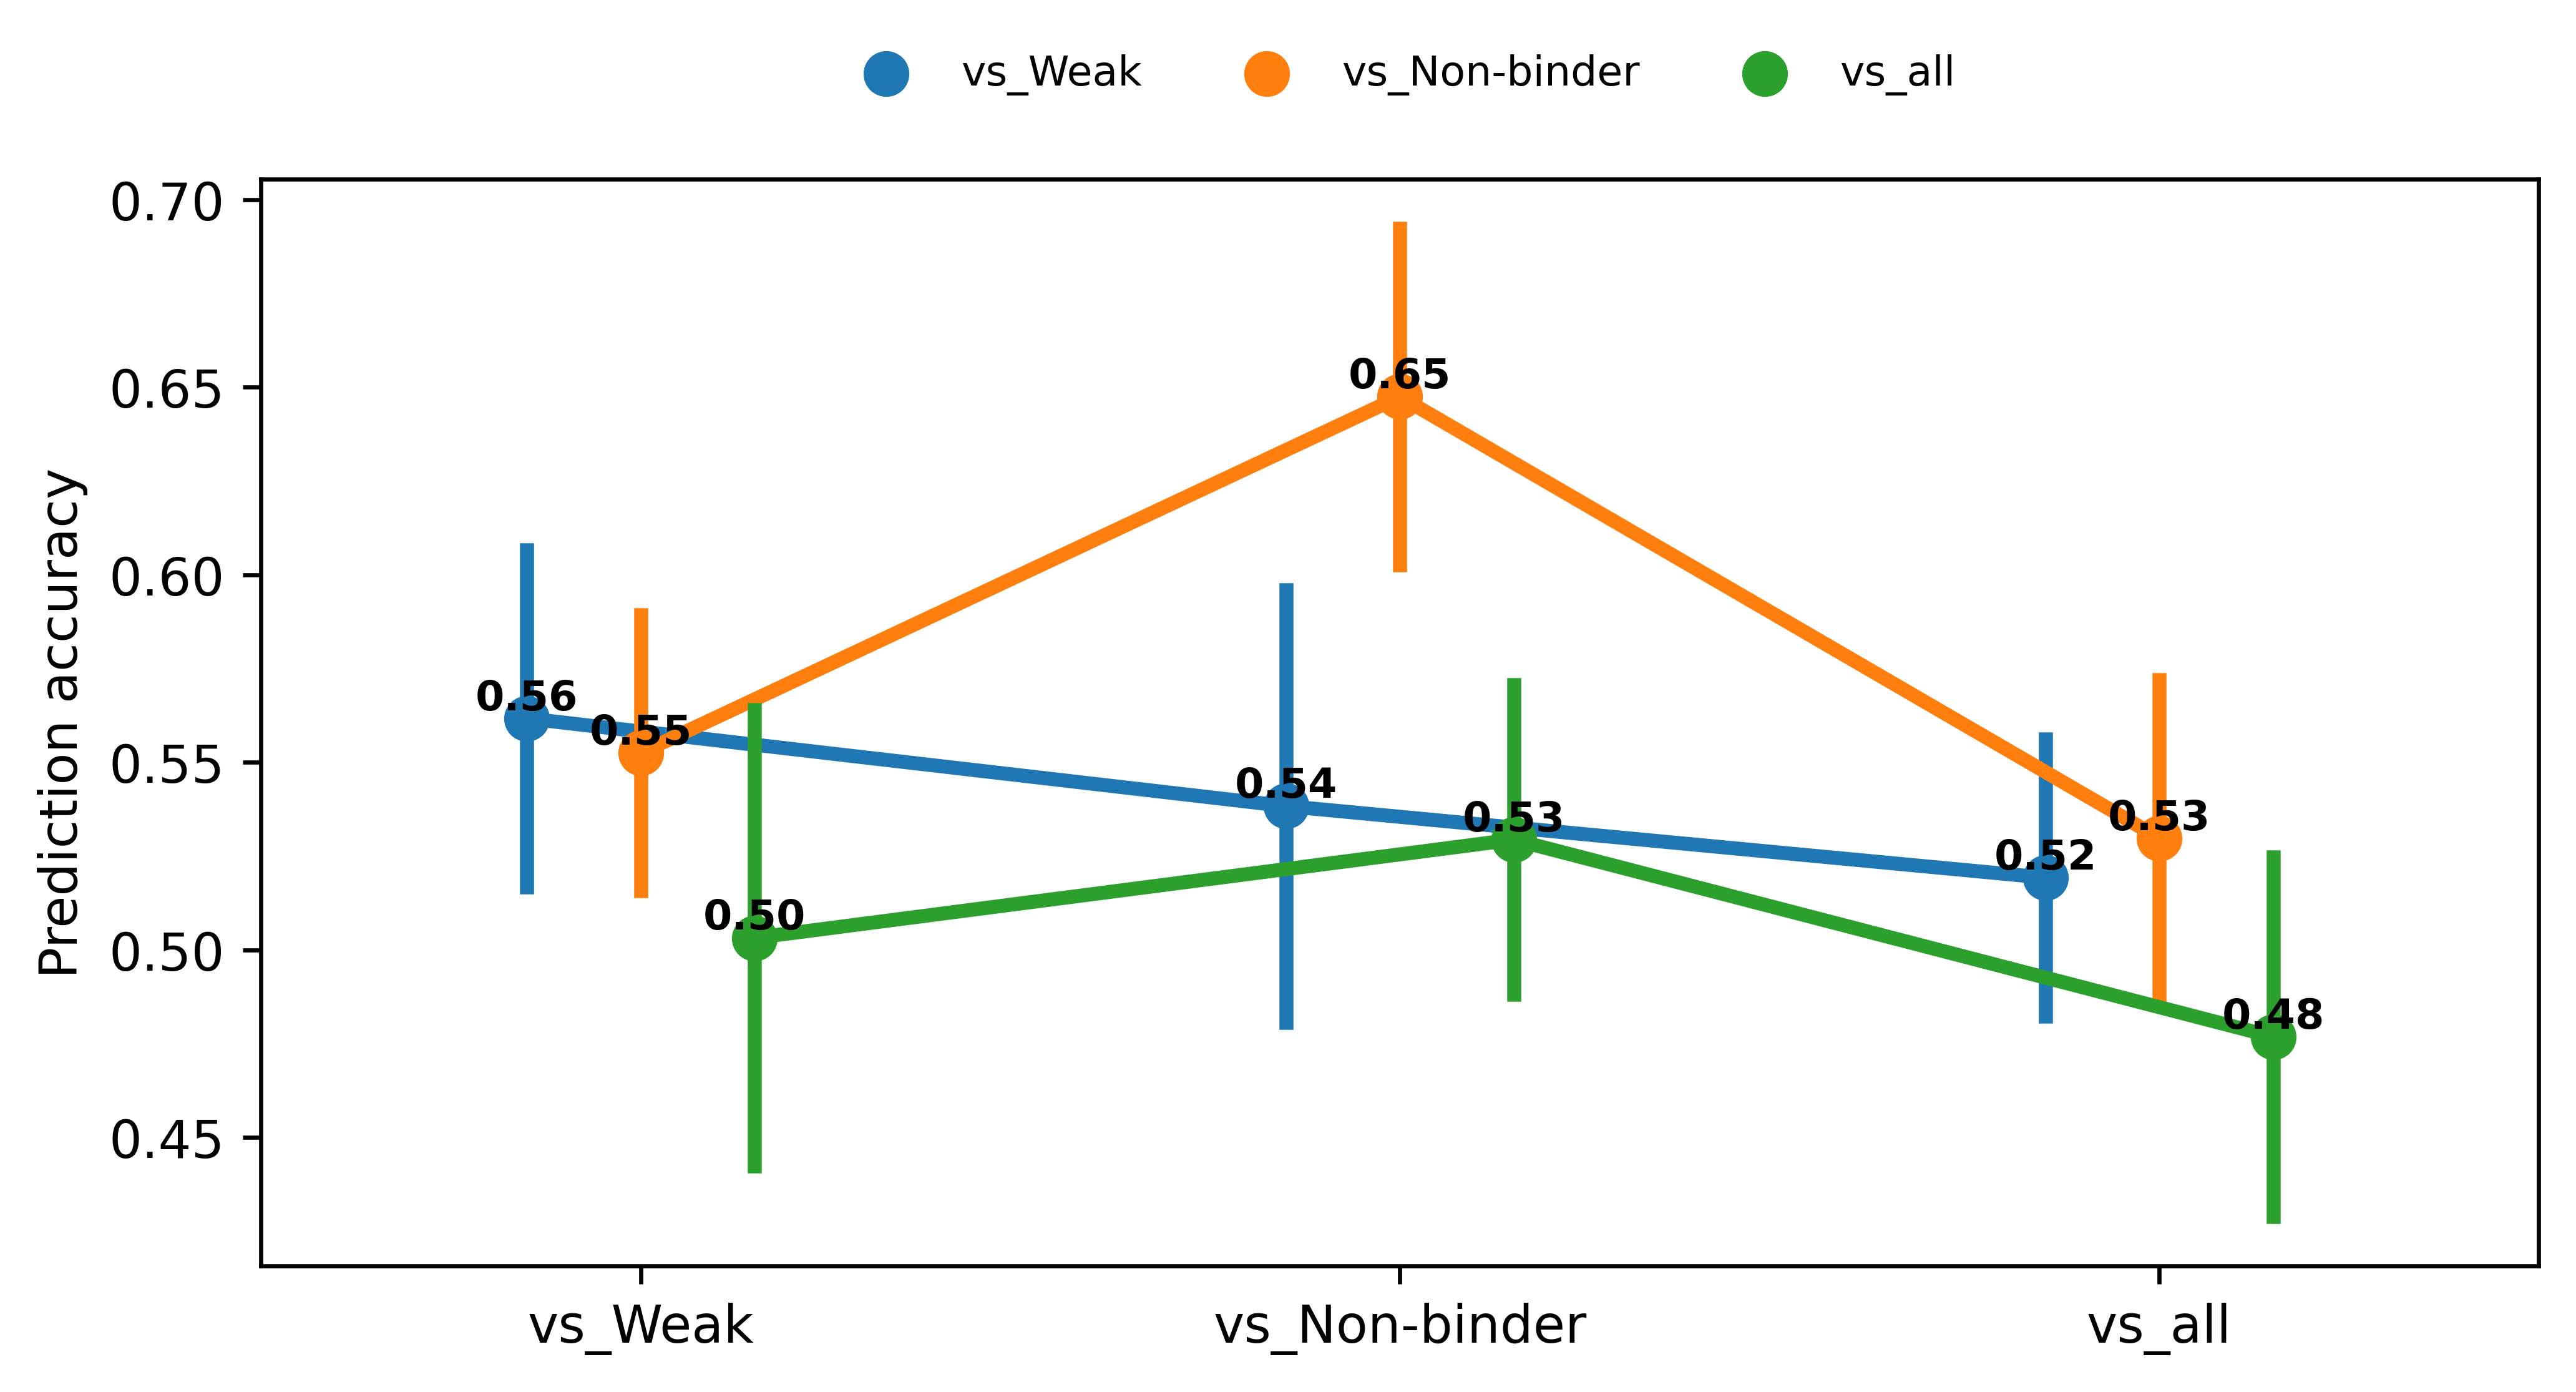

In [20]:
#now I need to plot openset performance
fig, ax = plt.subplots(figsize=(2.5 * 3.14, 1.2 * 3.14), dpi=600)
sns.pointplot(
    df_performance_nswa,
    y="accuracy",
    x="test_task",
    errorbar="sd",
    hue="train_task",
    dodge=0.3,
    ax=ax,
)

# Add legend horizontally on top of plot area, outside plot area
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=3,
    fontsize=8,
    frameon=False,
    # title="Model trained on",
    # title_fontsize=8,
)

ax.set_xlabel(None)
ax.set_ylabel("Prediction accuracy")

# Add text
for i, col in enumerate(ax.collections):
    for j, txt in enumerate(col.get_offsets()[:, 0]):
        ax.text(
            txt,
            col.get_offsets()[j, 1],
            f"{col.get_offsets()[j, 1]:.2f}",
            ha="center",
            va="bottom",
            color="black",
            fontsize=8,
            fontweight="bold",
        )

fig.show()

##### Why vs_all is the hardest task

In [26]:
train_task = "vs_all"
intersections = []
for target in tqdm(targets_balanced_list, desc="Targets"):
    for split in tqdm([0,1,2,42], desc="Splits"):
            train_data = Path('./data/processed') / target / train_task / f'split_{split}'/ 'train.pkl'
            train_dataset = pd.read_pickle(train_data)
            df_positive = train_dataset.query("Y_binary == 1")
            df_negative = train_dataset.query("Y_binary == 0")
            n_intersection = set(df_positive.Drug.values).intersection(set(df_negative.Drug.values))
            intersections.append([target, split, len(n_intersection)])
df_intersections = pd.DataFrame(intersections, columns=["target", "split", "intersection"])

Targets: 100%|██████████| 6/6 [00:00<00:00, 11.10it/s]
